# Problem Set 9
## Fundamentals of Simulation Methods, WiSe 20/21
#### Author: Elias Olofsson
#### Date: 2021-01-27

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Numerical Hydrodynamics - Part 1 
### 1.1. Advection in 1D (12 pts)

We solve the linear transport equation in 1D for some quantity $q(x,t)$, governed by the relation
\begin{equation}
    \frac{\partial q(x, t)}{\partial t}+v \frac{\partial q(x, t)}{\partial x}=0, 
\end{equation}
 and where $v$ is some positive constant. We discretize this partial differential equation using three different stencils for approximation of the spatial derivative. First we use the symmetric scheme
\begin{equation}
    q_{i}^{(n+1)}=q_{i}^{(n)}-v \frac{q_{i+1}^{(n)}-q_{i-1}^{(n)}}{2 \Delta x} \Delta t
\end{equation}
where $\Delta x$ and $\Delta t$ are the cell size and time step size respectivley. Note that the index $i$ refers to spatially different cells, while index $n$ refers to the stepping in time. Then we also use the *upwind* scheme as per
\begin{equation}
    q_{i}^{(n+1)}=q_{i}^{(n)}-v \frac{q_{i}^{(n)}-q_{i-1}^{(n)}}{\Delta x} \Delta t,
\end{equation}
as well as the corresponding *downwind* scheme
\begin{equation}
    q_{i}^{(n+1)}=q_{i}^{(n)}-v \frac{q_{i+1}^{(n)}-q_{i}^{(n)}}{\Delta x} \Delta t.
\end{equation}
We let the inital conditions on the domain $x \in [-L/2, L/2]$ be set to
\begin{equation}
    q(x, 0)=\left\{\begin{array}{lll}
1 & \text { for } & x<0 \\
0 & \text { for } & x \geq 0
\end{array}\right.
\end{equation}
with the Dirichlet boundary conditions
\begin{align}
    q(-L / 2, t)&=1\\
    q(L / 2, t)&=0.
\end{align}
For a domain discretized into $N$ equally sized cells with index $i \in \{0,...,N-1\}$, we choose to implement the boundary conditions using one ghost cell at each end of the domain, thus yielding a total of $N+2$ cells. To reflect the Dirichlet boundary conditions, we update the value in these two ghost cells after each integration time step as per
\begin{align}
    q_{i=-1}^{(n)} &= 2\cdot q(-L/2, t) - q_{i=0}^{(n)}\\
    q_{i=N}^{(n)} &= 2 \cdot q(L/2, t) - q_{i=N-1}^{(n)}
\end{align}
such that the boundary conditions are correctly represented. We integrate in time from $t=0$ to $t=3$, using $N\_steps =100$ equally sized time steps.


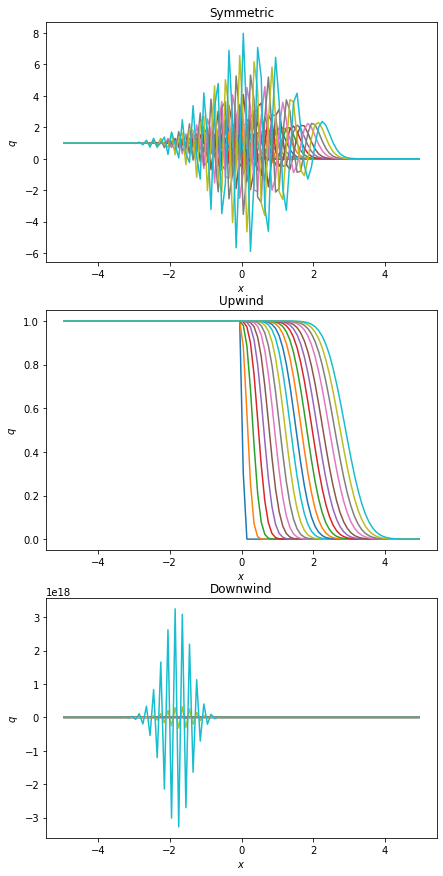

In [2]:
# Parameters
N         = 100  # Number of cells.
L         = 10   # Length of 1D domain.
v         = 1    # Advection coefficient.
T         = 3    # Integration time.
N_steps   = 100  # Number of timesteps.
plot_freq = 5    # Plot result every n:th iteration.

# Initial conditions. 
threshold    = 0
q_init_left  = 1   # q(x,0) = q_init_left  for x < threshold
q_init_right = 0   # q(x,0) = q_init_right for x >= threshold

# Dirichlet boundary conditions at x = ±L/2.
q_left  = 1 
q_right = 0 

# Numerical methods to use.
methods = ['Symmetric', 'Upwind', 'Downwind']

# -----------------------------------------------
# Timestep size and cell size. 
dt = T/N_steps 
dx = L/N

# Position vector (Excluding ghost cells).
x = np.linspace(-(L-dx)/2, (L-dx)/2, N) 

# Create subplot.
fig, ax = plt.subplots(len(methods), 1, figsize=(7,5*len(methods)))

# For each of the methods.
for i, method in enumerate(methods):
    
    # Pre-allocate q (Including ghost cells).
    q = np.zeros(N+2)

    # Assign inital conditions.
    q[1:-1][x < threshold]  = q_init_left
    q[1:-1][x >= threshold] = q_init_right

    # Apply boundary conditions. 
    q[0]  = 2*q_left  - q[1]
    q[-1] = 2*q_right - q[-2]

    # Main simulation loop.
    t = 0
    while t < T: 
        # Step in time.
        if method == 'Symmetric':
            q[1:-1] = q[1:-1] - v*dt/dx*(q[2:] - q[:-2])/2
        elif method == 'Upwind':
            q[1:-1] = q[1:-1] - v*dt/dx*(q[1:-1] - q[:-2])    
        elif method == 'Downwind':
            q[1:-1] = q[1:-1] - v*dt/dx*(q[2:] - q[1:-1])

        # Apply boundary conditions.
        q[0]  = 2*q_left  - q[1]
        q[-1] = 2*q_right - q[-2]

        # Plot results.
        if int(t/dt) % plot_freq == 0:
            ax[i].plot(x,q[1:-1])

        # Update time.
        t += dt
    
    # Plot settings.
    ax[i].set_title(method)
    ax[i].set_xlabel('$x$')
    ax[i].set_ylabel('$q$')
     
plt.show()

As we can see in the figure above, the only stable method is the *upwind* scheme, where only values of $q$ in the negative direction in $x$ is used in discrete integration. Both the *symmetric* and the *downwind* schemes are very unstable, and yield solutions that oscillate wildly. 

One should note however that the differentiation between the upwind and downwind schemes are determined by the sign of the constant parameter $v$, i.e. the direction of transport of the quantity $q$. Thus, if the sign of $v$ were switched, the numerical schemes above corresponding up *upwind* and *downwind*, have to be interchanged.

The reason for the stability of the upwind methods is that the scheme correctly reflects that 'information' is strictly flowing in only one orientation, i.e. to the right in the figure, and thus all cells are updated using only values at its own position and to the left of the cell itself. On the other hand, both the downwind and the symmetric methods use information cells to the right of their positions, which breaks the supposedly strict flow of information to the right. Thus, as a result, both of these methods become unstable.

We can also note the numerical diffusion in the upwind scheme, where the discontinuous initial state gets smoothed out over time.

We investigate this further, from now on only using the **upwind** scheme. We leave everything as in the previous simulation, but change the boundary condition on the left side to
\begin{equation}
    q(-L / 2, t) = 0.5,
\end{equation}
and plot the result.

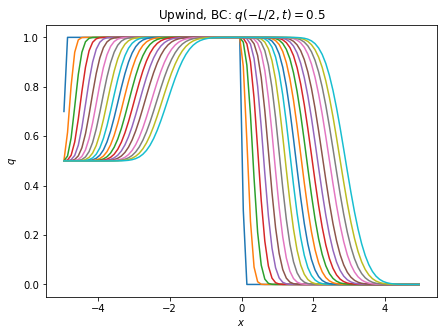

In [3]:
# Parameters
N         = 100  # Number of cells.
L         = 10   # Length of 1D domain.
v         = 1    # Advection coefficient.
T         = 3    # Integration time.
N_steps   = 100  # Number of timesteps.
plot_freq = 5    # Plot every n:th iteration.

# Initial conditions. 
threshold    = 0
q_init_left  = 1   # q(x,0) = q_init_left  for x < threshold
q_init_right = 0   # q(x,0) = q_init_right for x >= threshold

# Dirichlet boundary conditions at x = ±L/2.
q_left  = 0.5 
q_right = 0 

# -----------------------------------------------
# Timestep size and cell size. 
dt = T/N_steps 
dx = L/N

# Position vector (Excluding ghost cells).
x = np.linspace(-(L-dx)/2, (L-dx)/2, N) 

# Create plot.
plt.figure(figsize=(7,5))

# Pre-allocate q (Including ghost cells).
q = np.zeros(N+2)

# Assign inital conditions.
q[1:-1][x < threshold]  = q_init_left
q[1:-1][x >= threshold] = q_init_right

# Apply boundary conditions. 
q[0]  = 2*q_left  - q[1]
q[-1] = 2*q_right - q[-2]

# Main simulation loop.
t = 0
while t < T: 
    # Step in time.
    q[1:-1] = q[1:-1] - v*dt/dx*(q[1:-1] - q[:-2])    
    
    # Apply boundary conditions.
    q[0]  = 2*q_left  - q[1]
    q[-1] = 2*q_right - q[-2]

    # Plot results.
    if int(t/dt) % plot_freq == 0:
        plt.plot(x,q[1:-1])

    # Update time.
    t += dt

    # Plot settings.
    plt.title('Upwind, BC: $q(-L/2, t) = 0.5$')
    plt.xlabel('$x$')
    plt.ylabel('$q$')
     
plt.show()

Here we can clearly see the rightward 'flow' of the left boundary condition into the domain, showcasing the linear transport equation's main property.

We reset the simulation to the original parameters, and instead set the right boundary condition to
\begin{equation}
    q(L / 2, t) = 0.5,
\end{equation}
and plot the result.

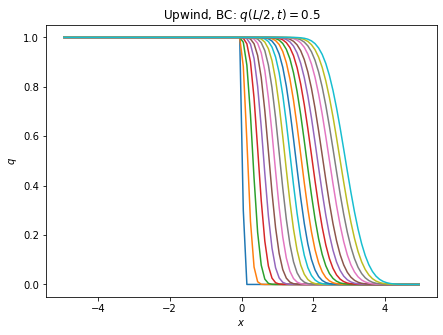

In [4]:
# Parameters
N         = 100  # Number of cells.
L         = 10   # Length of 1D domain.
v         = 1    # Advection coefficient.
T         = 3    # Integration time.
N_steps   = 100  # Number of timesteps.
plot_freq = 5    # Plot every n:th iteration.

# Initial conditions. 
threshold    = 0
q_init_left  = 1   # q(x,0) = q_init_left  for x < threshold
q_init_right = 0   # q(x,0) = q_init_right for x >= threshold

# Dirichlet boundary conditions at x = ±L/2.
q_left  = 1 
q_right = 0.5

# -----------------------------------------------
# Timestep size and cell size. 
dt = T/N_steps 
dx = L/N

# Position vector (Excluding ghost cells).
x = np.linspace(-(L-dx)/2, (L-dx)/2, N) 

# Create plot.
plt.figure(figsize=(7,5))

# Pre-allocate q (Including ghost cells).
q = np.zeros(N+2)

# Assign inital conditions.
q[1:-1][x < threshold]  = q_init_left
q[1:-1][x >= threshold] = q_init_right

# Apply boundary conditions. 
q[0]  = 2*q_left  - q[1]
q[-1] = 2*q_right - q[-2]

# Main simulation loop.
t = 0
while t < T: 
    # Step in time.
    q[1:-1] = q[1:-1] - v*dt/dx*(q[1:-1] - q[:-2])    
    
    # Apply boundary conditions.
    q[0]  = 2*q_left  - q[1]
    q[-1] = 2*q_right - q[-2]

    # Plot results.
    if int(t/dt) % plot_freq == 0:
        plt.plot(x,q[1:-1])

    # Update time.
    t += dt

    # Plot settings.
    plt.title('Upwind, BC: $q(L/2, t) = 0.5$')
    plt.xlabel('$x$')
    plt.ylabel('$q$')
     
plt.show()

Here we see no difference in results compared to the original simulation setup, even though the right boundary condition has been changed. Clearly, the simulation is indepedent of the right boundary condition, since we have a constant and strict transport of the quantity $q$ to the right in the picture.

We reset the simulation to the original parameters again, and now choose a $10$ times smaller time step, i.e. by setting the number of time steps $N\_steps$ to $1000$.

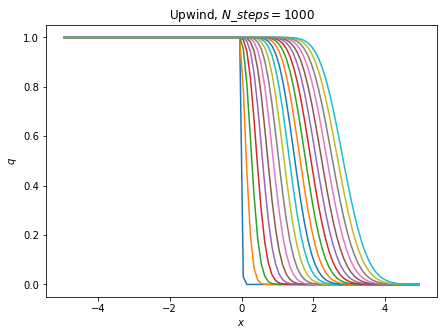

In [5]:
# Parameters
N         = 100  # Number of cells.
L         = 10   # Length of 1D domain.
v         = 1    # Advection coefficient.
T         = 3    # Integration time.
N_steps   = 1000 # Number of timesteps.
plot_freq = 50   # Plot every n:th iteration.

# Initial conditions. 
threshold    = 0
q_init_left  = 1   # q(x,0) = q_init_left  for x < threshold
q_init_right = 0   # q(x,0) = q_init_right for x >= threshold

# Dirichlet boundary conditions at x = ±L/2.
q_left  = 1 
q_right = 0

# -----------------------------------------------
# Timestep size and cell size. 
dt = T/N_steps 
dx = L/N

# Position vector (Excluding ghost cells).
x = np.linspace(-(L-dx)/2, (L-dx)/2, N) 

# Create plot.
plt.figure(figsize=(7,5))

# Pre-allocate q (Including ghost cells).
q = np.zeros(N+2)

# Assign inital conditions.
q[1:-1][x < threshold]  = q_init_left
q[1:-1][x >= threshold] = q_init_right

# Apply boundary conditions. 
q[0]  = 2*q_left  - q[1]
q[-1] = 2*q_right - q[-2]

# Main simulation loop.
t = 0
while t < T: 
    # Step in time.
    q[1:-1] = q[1:-1] - v*dt/dx*(q[1:-1] - q[:-2])    
    
    # Apply boundary conditions.
    q[0]  = 2*q_left  - q[1]
    q[-1] = 2*q_right - q[-2]

    # Plot results.
    if int(t/dt) % plot_freq == 0:
        plt.plot(x,q[1:-1])

    # Update time.
    t += dt

    # Plot settings.
    plt.title('Upwind, $N\_steps = 1000$')
    plt.xlabel('$x$')
    plt.ylabel('$q$')
     
plt.show()

Here we can see that there is no real difference in these results compared to the original simulation, with the exception being that the obtained reuslt is much smoother.

We reset the simulation and do the opposite instead, by setting the time step size to $10$ times larger than the original value, i.e. by changing the number of time steps $N\_steps$ to $10$. 

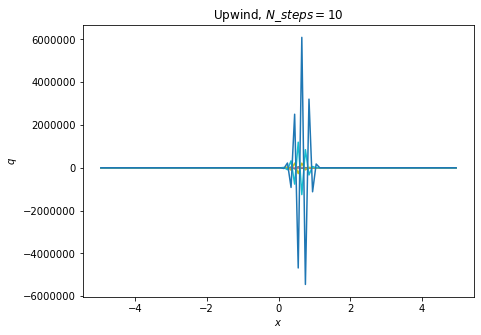

In [6]:
# Parameters
N         = 100  # Number of cells.
L         = 10   # Length of 1D domain.
v         = 1    # Advection coefficient.
T         = 3    # Integration time.
N_steps   = 10   # Number of timesteps.
plot_freq = 1    # Plot every n:th iteration.

# Initial conditions. 
threshold    = 0
q_init_left  = 1   # q(x,0) = q_init_left  for x < threshold
q_init_right = 0   # q(x,0) = q_init_right for x >= threshold

# Dirichlet boundary conditions at x = ±L/2.
q_left  = 1 
q_right = 0

# -----------------------------------------------
# Timestep size and cell size. 
dt = T/N_steps 
dx = L/N

# Position vector (Excluding ghost cells).
x = np.linspace(-(L-dx)/2, (L-dx)/2, N) 

# Create plot.
plt.figure(figsize=(7,5))

# Pre-allocate q (Including ghost cells).
q = np.zeros(N+2)

# Assign inital conditions.
q[1:-1][x < threshold]  = q_init_left
q[1:-1][x >= threshold] = q_init_right

# Apply boundary conditions. 
q[0]  = 2*q_left  - q[1]
q[-1] = 2*q_right - q[-2]

# Main simulation loop.
t = 0
while t < T: 
    # Step in time.
    q[1:-1] = q[1:-1] - v*dt/dx*(q[1:-1] - q[:-2])    
    
    # Apply boundary conditions.
    q[0]  = 2*q_left  - q[1]
    q[-1] = 2*q_right - q[-2]

    # Plot results.
    if int(t/dt) % plot_freq == 0:
        plt.plot(x,q[1:-1])

    # Update time.
    t += dt

    # Plot settings.
    plt.title('Upwind, $N\_steps = 10$')
    plt.xlabel('$x$')
    plt.ylabel('$q$')
     
plt.show()

Here we see that the simulation becomes unstable again. Thus, using the upwind scheme is not sufficient for a stable simualtion, but we also need to choose an appropriate size of the time step $\Delta t$, given the spatial resolution $\Delta x$ and the speed of transport $v$. These requirements are described by the CFL-condition, which dictates that a time step must necessarily fullfill
\begin{equation}
    \Delta t \leq \frac{\Delta x}{v}, 
\end{equation}
for the simulation to be stable. In this specific form, the condition can be interpreted as the requirement for the time step to be smaller than the time it takes for the transport of the medium $q$ to cross one cell of size $\Delta x$.

## 1.2. General-purpose 1D advection subroutine (8 pts)

The advection problem at hand can be written as a general scalar conservation law
\begin{equation}
    \frac{\partial q}{\partial t}+\nabla \cdot \boldsymbol{f}(q)=0,
\end{equation}
in multiple dimensions, where the vector valued function $\boldsymbol{f}$ is called a *flux function*, and is in general a non-linear function of $q$. Taking this equation to the 1D case, it simply becomes
\begin{equation}
    \frac{\partial q}{\partial t}+ \frac{\partial f(q)}{\partial x}=0,
\end{equation}
in conservative form, or 
\begin{equation}
    \frac{\partial q}{\partial t}+  \frac{\partial f(q)}{\partial q}\frac{\partial q}{\partial x}=0,
\end{equation}
in primitive form. In order to match this equation to the orginal formulation of the advection problem at the start of this exercise sheet, we can easily see that the flux function in question is
\begin{equation}
    f(q) = vq,
\end{equation}
where $v = v(x)$ is the bulk motion in the domain and $q = q(x,t)$ is the density of the quantity of interest. Using the finite volume approach of integrating the conservative differential form over a discrete cell and a discrete time step, we obtain the numerical update scheme
\begin{equation}
    q_{i}^{n+1}=q_{i}^{n}-\frac{\Delta t}{\Delta x}\left(F_{i+1 / 2}^{n}-F_{i-1 / 2}^{n}\right),
\end{equation}
in integral form, where the cell averages at position $x_i$ and time $t_n$ are defined as
\begin{equation}
    q_{i}^{n} \approx \frac{1}{\Delta x} \int_{x_{i}-1 / 2}^{x_{i+1 / 2}} q\left(x, t_{n}\right) d x,
\end{equation}
and the numerical flux functions at the cell interfaces are defined as
\begin{equation}
    F_{i \pm 1 / 2}^{n} \approx \frac{1}{\Delta t} \int_{t_{n}}^{t_{n+1}} f\left(q\left(x_{i \pm 1 / 2}, t\right)\right) d t.
\end{equation}
In order to complete the numerical scheme obtained above, we need a way to estimate the numerical fluxes. We can recognize that the upwind scheme is in this formulation defined as
\begin{equation}
    F_{i+1 / 2}^{n}=\left\{\begin{array}{ll}
    f\left(q_{i}^{n}\right) & \text { if } f^{\prime}>0 \\
    f\left(q_{i+1}^{n}\right) & \text { if } f^{\prime}<0,
\end{array}\right.
\end{equation}
which will give moderate numerical accuracy and is relatively easy to implement. Noting that the derivative of the flux function is
\begin{equation}
    f^{\prime}(q) = \frac{\partial}{\partial q}\left(vq \right) = v,
\end{equation}
we then have the flux function estimates
\begin{equation}
    F_{i+1 / 2}^{n}=\left\{\begin{array}{ll}
    v_{i+1/2} q_{i}^{n} & \text { if } v_{i+1/2}>0 \\
    v_{i+1/2} q_{i+1}^{n} & \text { if } v_{i+1/2}<0,
\end{array}\right.
\end{equation}
with the velocities $v_{i \pm 1 / 2}$ at the cell interfaces, which we use to numerically solve the problem.

Thus implementing this numerical scheme, we first check for validity by using the same parameters as above with a constant velocity $v(x) = 1$ and plot the result.

In [7]:
def advect(q, v, dx, dt):
    '''
    Integrate one step in time for a general 1D numerical advection problem. 
    Using the sign of the local derivative (sign of velocity v) to choose 
    the appropriate cells for the Upwind scheme.
    
    Parameters:
    -----------
    q: np.array shape=(N+2,)
        Array containing quantities q at the N cell centers, and at the two 
        ghost cells. The first and last elements corresponds to the ghost 
        cells at each end of the domain.
    v: np.array shape=(N+1,)
        Array of transport velocites at each cell interface.
    dx: double
        Size of cell.
    dt: double
        Size of time step.
    
    Returns:
    --------
    np.array shape=(N,)
        Solution q, propagated one step dt in time.
    '''
    # Quantity q, vectors of shape=(N,).
    qm = q[1:-1] # center adjusted, q_i
    qr = q[2:]   # right adjusted,  q_i+1
    ql = q[:-2]  # left adjusted,   q_i-1

    # Velocities v, vectors of shape=(N,). 
    vr = v[1:]   # right velocity, v_i+1/2
    vl = v[:-1]  # left velcocity, v_i-1/2
    
    # Numerical flux functions, vectors of shape=(N,).
    # Using upwind scheme, determined by sign of local derivative. 
    Fr = vr * (qm*(vr>=0) + qr*(vr<0)) # Right cell interface, i+1/2
    Fl = vl * (ql*(vl>=0) + qm*(vl<0)) # Left cell interface,  i-1/2
    
    # Step in time.
    q_new = qm - dt/dx*(Fr - Fl) 
    
    return q_new

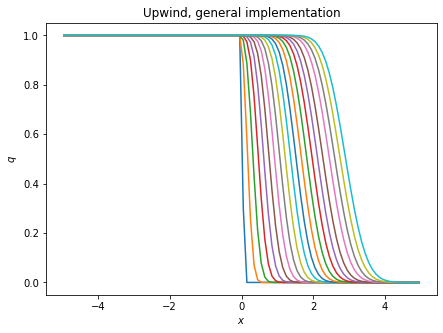

In [8]:
# Parameters
N         = 100  # Number of cells.
L         = 10   # Length of 1D domain.
T         = 3    # Integration time.
N_steps   = 100  # Number of timesteps.
plot_freq = 5    # Plot every n:th iteration.

# Initial conditions. 
threshold    = 0
q_init_left  = 1   # q(x,0) = q_init_left  for x < threshold
q_init_right = 0   # q(x,0) = q_init_right for x >= threshold

# Dirichlet boundary conditions at x = ±L/2.
q_left  = 1 
q_right = 0

# -----------------------------------------------
# Timestep size and cell size. 
dt = T/N_steps 
dx = L/N

# Position vector (Excluding ghost cells).
x = np.linspace(-(L-dx)/2, (L-dx)/2, N) 

# Transport velocity at cell interfaces.
v = np.ones(N+1)

# Create plot.
plt.figure(figsize=(7,5))

# Pre-allocate q (Including ghost cells).
q = np.zeros(N+2)

# Assign inital conditions.
q[1:-1][x < threshold]  = q_init_left
q[1:-1][x >= threshold] = q_init_right

# Apply boundary conditions. 
q[0]  = 2*q_left  - q[1]
q[-1] = 2*q_right - q[-2]

# Main simulation loop.
t = 0
while t < T: 
    # Step in time.
    q[1:-1] = advect(q, v, dx, dt)   
    
    # Apply boundary conditions.
    q[0]  = 2*q_left  - q[1]
    q[-1] = 2*q_right - q[-2]

    # Plot results.
    if int(t/dt) % plot_freq == 0:
        plt.plot(x,q[1:-1])

    # Update time.
    t += dt

    # Plot settings.
    plt.title('Upwind, general implementation')
    plt.xlabel('$x$')
    plt.ylabel('$q$')
     
plt.show()

We seemingly get the same result as obtained previously, so our implementation should reasonably be correct.

Now we instead choose a velocity profile as
\begin{equation}
v(x)=-\frac{2x}{L},
\end{equation}
and set the initial conditions to 
\begin{equation}
    q(x,0)=\left\{\begin{array}{ll}
    1 & \text { if } |x| \leq \frac{L}{4} \\
    0 & \text { otherwise } ,
\end{array}\right.
\end{equation}
with boundary conditions
\begin{equation}
    q(-L/2,t) = q(L/2,t) = 0,
\end{equation}
and solve the problem from time $t=0$ to $t=3$ with $100$ equally sized timesteps.

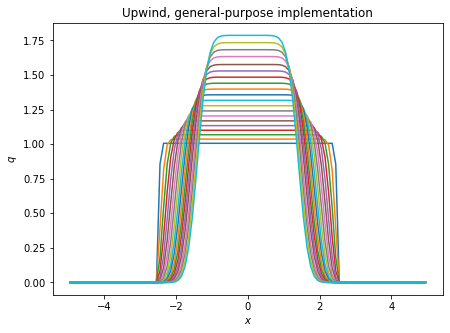

In [9]:
# Parameters
N         = 100  # Number of cells.
L         = 10   # Length of 1D domain.
T         = 3    # Integration time.
N_steps   = 100  # Number of timesteps.
plot_freq = 5    # Plot every n:th iteration.

# Initial conditions. 
threshold    = L/4
q_init_mid   = 1   # q(x,0) = q_init_mid   for |x| <= threshold
q_init_sides = 0   # q(x,0) = q_init_sides for |x| > threshold

# Dirichlet boundary conditions at x = ±L/2.
q_left  = 0 
q_right = 0

# -----------------------------------------------
# Timestep size and cell size. 
dt = T/N_steps 
dx = L/N

# Position vector (Excluding ghost cells).
x = np.linspace(-(L-dx)/2, (L-dx)/2, N) 

# Transport velocity at cell interfaces.
x_interface = np.linspace(-L/2, L/2, N+1)
v = -2*x_interface/L

# Create plot.
plt.figure(figsize=(7,5))

# Pre-allocate q (Including ghost cells).
q = np.zeros(N+2)

# Assign inital conditions.
q[1:-1][np.abs(x) <= threshold]  = q_init_mid
q[1:-1][np.abs(x) > threshold]   = q_init_sides

# Apply boundary conditions. 
q[0]  = 2*q_left  - q[1]
q[-1] = 2*q_right - q[-2]

# Main simulation loop.
t = 0
while t < T: 
    # Step in time.
    q[1:-1] = advect(q, v, dx, dt)   
    
    # Apply boundary conditions.
    q[0]  = 2*q_left  - q[1]
    q[-1] = 2*q_right - q[-2]

    # Plot results.
    if int(t/dt) % plot_freq == 0:
        plt.plot(x,q[1:-1])

    # Update time.
    t += dt

    # Plot settings.
    plt.title('Upwind, general-purpose implementation')
    plt.xlabel('$x$')
    plt.ylabel('$q$')
     
plt.show()

As we can see in the figure, the converging velocity field collects the quantity $q$ in the center of the domain with increasingly higher density, which is the expected behaviour given the velocity profile and the properties of the transport equation. The asymptotic behaviour would be that all 'mass' accumulates at $x=0$, while nothing remains elsewhere in the domain. Changing the boundary conditions would however alter the equilibrium state, since we then would also have a flow of the quantity $q$ in from the sides as well. 